In [1]:
import time
!pip install ccxt
import ccxt
from time import gmtime, strftime
import datetime
import pandas as pd
print(ccxt.exchanges)

     |████████████████████████████████| 2.1MB 6.2MB/s 
     |████████████████████████████████| 163kB 33.3MB/s 
     |████████████████████████████████| 3.2MB 42.2MB/s 
     |████████████████████████████████| 1.3MB 37.7MB/s 
     |████████████████████████████████| 143kB 46.4MB/s 
     |████████████████████████████████| 235kB 41.4MB/s 
  Created wheel for yarl: filename=yarl-1.1.0-cp37-cp37m-linux_x86_64.whl size=241460 sha256=ced053e76f58b9cbe3d84715dc50ce31a9b1a12fca48f32a2789a4d07c673575
  Stored in directory: /root/.cache/pip/wheels/96/26/b9/7972042a1a69556ba7f38b8a301dc3a9ddac1b8f61f02fbfd8
Successfully built yarl
['aax', 'acx', 'aofex', 'ascendex', 'bequant', 'bibox', 'bigone', 'binance', 'binanceus', 'bit2c', 'bitbank', 'bitbay', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitkk', 'bitmart', 'bitmax', 'bitmex', 'bitpanda', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bitz', 'bl3p', 'bleutrade', 'braziliex', 'btcalpha', 'btcbox', 

In [2]:
# We define a function to get the bar from one currency to another. 
# We get at most 3000 data each time due to the exchange's transmision length limitation.
def get_bar_from_to(ex,symbol,period,start_time='2017-08-17 00:00:00',end_time='2021-03-05 23:59:59',length=3000,maxLoop=20):
  data = []
  stime = ex.parse8601(start_time) # ISO8601 is the format of time
  etime = ex.parse8601(end_time)
  loop_i = 0
  if ex.has['fetchOHLCV']:
    while stime < etime and loop_i < maxLoop:
      loop_i += 1
      try:
        ohlcvs = ex.fetch_ohlcv(symbol, period, stime, limit=length)
        #print(ex.iso8601(ex.milliseconds()),'loop_i=',loop_i, ' ,Fetched', len(ohlcvs), 'candles')
        if len(ohlcvs) > 1:
          first = ohlcvs[0][0]
          last = ohlcvs[-1][0]
          #print('[',ex.iso8601(first),'--', ex.iso8601(last),']')
          stime = int(last+ (last - first)/(len(ohlcvs)-1))
          data += ohlcvs
          time.sleep(1)
        else:
          return data
      except Exception as e:
        print(str(e))
  return data

from datetime import datetime

# format data as dataframe of pandas
# USDT: started from 2015-02-25
# BTC: started from 2014-09-17
# ETH: started from 2015-08-07
# the start time should not be prior to: 2015-08-07
# in ccxt, the start time seems not be prior to 2017-08-17
# 'BTC/USDT': the earliest is: 2017-08-17
# 'ETH/USDT': the earliest is: 2017-08-17
# start_time = '2017-08-17 00:00:00'
# end_time = '2021-03-05 23:59:59'
def getData(exchange, symbol, period, cols=['time','open','high','low','close','volume']):
  # set the start time
  start_time = '2017-08-17 00:00:00'
  if period == '1d':
    start_time = '2017-08-17 00:00:00'
  elif period == '1h':
    start_time = '2020-01-01 00:00:00'
  # set the end time
  end_time = '2021-03-05 23:59:59'

  data = get_bar_from_to(exchange, symbol, period, start_time, end_time)
  test = pd.DataFrame(data, columns=cols)

  # get the data before the end_time
  etime = exchange.parse8601(end_time)
  test = test.loc[ test['time'] <= etime ]
  # convert the time format
    # method 1
    # test['date'] = (test['time']/1000).apply(datetime.fromtimestamp)
    # method 2
  test['day'] = test['time'].apply(lambda x: exchange.iso8601(x)[:10])
  if period == '1h':
    test['hour'] = test['time'].apply(lambda x: exchange.iso8601(x)[:10] + ' ' + exchange.iso8601(x)[11:16])
  return test

# for a dataframe, get its columns (features)
def getCols(df):
  cols = []
  for col in df:
    cols.append(col)
  return cols

# get the copied data
def getCopy(df):
  cols = getCols(df)
  ti = pd.DataFrame()
  if 'hour' in cols: # hourly data
    ti = df[ ['day', 'hour', 'close'] ].copy()
  else: # daily data
    ti = df[ ['day', 'close'] ].copy()
  return ti

In [3]:
# MA (Moving Average)
  # ti, the dataframe (data)
  # win_size, the size of moving window
  # col, by which column to calculate the moving average
def MA(ti, win_size=12, col='close'):
  colName = 'MA' + str(win_size)
  ti[colName] = ti['close'].transform(lambda x: x.rolling(window = win_size).mean())
  return colName

# Exponential Moving Averages (EMA)
  # ti, the dataframe (data)
  # win_size, the size of EMA
  # col, by which column to calculate the EMA
def EMA(ti, win_size=12, col='close'):
  colName = 'EMA' + str(win_size)
  ti[colName] = ti['close'].transform(lambda x: x.ewm(span=win_size, adjust=False).mean())
  return colName

# DIF, EMA_fast - EMA_slow, get the momentum
# therefore, win_size1 < win_size2
def DIF(ti, win_size1=12, win_size2=26):
  col1 = 'EMA' + str(win_size1)
  col2 = 'EMA' + str(win_size2)
  cols = getCols(ti)
  if col1 not in cols:
    EMA(ti, win_size1)
  if col2 not in cols:
    EMA(ti, win_size2)
  colName = 'DIF'
  ti[colName] = ti[col1] - ti[col2]
  return colName

# SIG = EMA(DIF, 9) /also know as DEA/DEM
# for Moving Average Convergence Divergence (MACD)
def SIG(ti, _span=9):
  col = 'DIF'
  cols = getCols(ti)
  if col not in cols:
    print('you should calculate DIF firstly')
    return
  colName = 'SIG'
  ti[colName] = ti[col].transform(lambda x: x.ewm(span=_span, adjust=False).mean())
  return colName

# MACD = DIF − SIG
  # which can function as a trigger for buy and sell signals
  # buy, when the DIF crosses above its signal line
  # sell, when the DIF crosses below the signal line
def MACD_indicator(ti, win_size1=12, win_size2=26, _span=9):
  DIF(ti, win_size1, win_size2)
  SIG(ti, _span)
  colName = 'MACD'
  ti[colName] = ti['DIF'] - ti['SIG']
  return colName

# calculate the DIF between fast_EMA and slow_EMA
  # If short-term moving average is above long-term moving average
  # it also indicates price is still in an up trend
  # Buy when short-term moving average is above long-term moving average
  # sell when short-term moving average is below long-term moving average
def EMA_indicator(ti, win_size1=12, win_size2=26):
  DIF(ti, win_size1, win_size2)
  return 'DIF'

In [4]:
import numpy as np

# calculate the signal when to buy and sell
# MACD or EMA
# when 2 lines cross over each other, that is the signal to trade (buy or sell)
def whenToTrade(ti, colName="MACD"):
  # add signal to buy or sell, default value: 0
  ti['signal'] = 0
  size = len(ti)
  for i in range(1, size):
    pre = ti[colName][i-1]
    hist = ti[colName][i]
    crossover = False
    # if hist * pre < 0, it means there is a crossover
    if pre*hist <= 0:
      crossover = True
    # cross from beneath or above
    # if hist>0, it means the crossover from beneath: buy
    # if hist<0, it means the crossover from above: sell
    direction = False
    if hist > 0:
      direction = True
    # set signal to buy or sell
    # 1 means to buy
    # -1 means to sell
    if crossover:
      if direction:
        ti.loc[i, 'signal'] = 1
      else:
        ti.loc[i, 'signal'] = -1
  return

# strategy is quite simple:
  # when signal=1 -> buy and signal=-1 -> sell
  # and wait next buy-signal to buy
  # then record the points at every buy-signal and sell-signal
  # for each one, calculate the return:
    # return = ((buy-siganl point) - (sell-signal point)) / (buy-siganl point)
def recordBuySell(ti):
  # to calculate the return
  buy_points = [] # when signal is buy, record the close points
  sell_points = [] # when signal is sell, record the close points

  # to calculate the holding unit-time 
    # (for example, for daily data, holding time is how many days)
    # (for example, for hourly data, holding time is how many hours)
    # generally speaking, the more time you hold, the more return it will be
  buy_time = [] # also record the index of buy-signal
  sell_time = [] # also record the index of sell-signal

  size = len(ti)
  start = False # when first buy-signal appears, it starts to buy and sell
  for i in range(size):
    signal = ti.loc[i, 'signal']
    point = ti.loc[i, 'close']
    # wait the first buy-signal to appear
    if signal == 1:
      start = True

    if start and signal == 1:
      buy_points.append(point)
      buy_time.append( i )
    elif start and signal == -1:
      sell_points.append(point)
      sell_time.append( i )
    else:
      pass
  # the length of buy_points should be equal to that of sell_points
  buy_len = len(buy_points)
  sell_len = len(sell_points)
  if buy_len > sell_len:
    # the last close point should be added to the sell_points list
    #print( ti.loc[size-1, 'close'] )
    last_point = ti.loc[size-1, 'close']
    sell_points.append(last_point)
    sell_time.append( size-1 )
  return buy_points, sell_points, buy_time, sell_time

# Performance analysis at different parameter
# such as: 
  # 1. average return per trade, 
  # 2. accumulated return
  # 3. win ratio
  # 4. max win
  # 5. loss percentage
def performance(buy_points, sell_points, buy_time, sell_time):
  rtn = []
  size = len(buy_points)
  win_count = 0

  detail = []
  for i in range(size):
    buy_price = buy_points[i]
    sell_price = sell_points[i]
    # add return
    r = (sell_price-buy_price)/buy_price
    #r = round(r, 2) # round to 2 decimals
    b_time = buy_time[i]
    s_time = sell_time[i]
    interval = s_time - b_time
    rtn.append( r )
    detail.append( [r, interval, b_time, s_time] )
    if r > 0:
      win_count = win_count + 1

  rtn = np.array(rtn)
  # average return per trade
  avgRtn = rtn.mean()
  avgRtn = round(avgRtn, 3) # round to 3 decimals

  # accumulated return
  accRtn = rtn.sum()
  accRtn = round(accRtn, 3) # round to 3 decimals

  # win ratio
  winRatio = win_count/size
  winRatio = round(winRatio, 3) # round to 3 decimals

  # max win/loss percentage
  winMax = rtn.max()
  winMax = round(winMax, 3)
  lossMax = rtn.min()
  lossMax = round(lossMax, 3)
  # if there is no loss at all
  if lossMax > 0:
    lossMax = 0
  # the performance info
  info = {}
  info['average'] = avgRtn
  info['accumulated'] = accRtn
  info['win_ratio'] = winRatio
  info['max_win'] = winMax
  info['max_loss'] = lossMax
  return info, detail

# data is: btc_day, eth_day, btc_hour, eth_hour
# 12, 26, 9 are the parameters setting on MACD
# win_size1 <  win_size2
def MACD_launch(data, win_size1=12, win_size2=26, span_win=9):
  ti = getCopy(data)
  # calculate MACD firstly
  colName = MACD_indicator(ti, win_size1, win_size2, span_win)
  # set signal to buy or sell
  whenToTrade(ti, colName)
  # use strategy to buy and sell
  buy_points, sell_points, buy_time, sell_time = recordBuySell(ti)
  # evaluate the performance
  info, detail = performance(buy_points, sell_points, buy_time, sell_time)
  #ti.to_csv('test.csv')
  return info, detail

# data is: btc_day, eth_day, btc_hour, eth_hour
# 12, 26 are the parameters setting on EMA
# win_size1 <  win_size2
def EMA_launch(data, win_size1=12, win_size2=26):
  ti = getCopy(data)
  # calculate the fast and slow EMAs, get the difference that is the indicator
  colName = EMA_indicator(ti, win_size1, win_size2)
  # set signal to buy or sell
  whenToTrade(ti, colName)
  # use strategy to buy and sell
  buy_points, sell_points, buy_time, sell_time = recordBuySell(ti)
  # evaluate the performance
  info, detail = performance(buy_points, sell_points, buy_time, sell_time)
  #ti.to_csv('test.csv')
  return info, detail

# parameters for MACD: p1, p2, p3
# p1: 5 - 30
# p2: p1+5 - p1+30 
# p3: 5 - 20
  # it is 25*25*15=9375 different-parameter tries
  # for daily data, it takes about 10 minutes
  # for hourly data, it takes about 1.5 hour
# record the performance of every try in csv file:
  # 1. average return per trade, 
  # 2. accumulated return
  # 3. win ratio
  # 4. max win
  # 5. loss percentage
def researchMACD(data, fileName):
  cols = ['p1', 'p2', 'p3', 'average', 'accumulated', 'win_ratio', 'max_win', 'max_loss']
  MACD_record = pd.DataFrame(columns = cols)

  for p1 in range(5, 30):
    for p2 in range(p1+5, p1+30):
      for p3 in range(5, 20):
        info, detail = MACD_launch(data, p1, p2, p3)
        info['p1'] = p1
        info['p2'] = p2
        info['p3'] = p3
        MACD_record = MACD_record.append(info, ignore_index = True)
  fileName = 'macd_' + fileName + '.csv'
  MACD_record.to_csv(fileName)
  return 

# parameters for EMA: p1, p2
# EMA_fast, p1: 5 - 50
# EMA_slow, p2: p1+5 - p1+50 
  # it is 45*45=2025 different-parameter tries
  # for daily data, it takes about 2 minutes
  # for hourly data, it takes about 15 minutes
# record the performance of every try in csv file:
  # 1. average return per trade, 
  # 2. accumulated return
  # 3. win ratio
  # 4. max win/loss percentage
def researchEMA(data, fileName):
  cols = ['p1', 'p2', 'average', 'accumulated', 'win_ratio', 'max_win', 'max_loss']
  EMA_record = pd.DataFrame(columns = cols)

  for p1 in range(5, 50):
    for p2 in range(p1+5, p1+50):
      info, detail = EMA_launch(data, p1, p2)
      info['p1'] = p1
      info['p2'] = p2
      EMA_record = EMA_record.append(info, ignore_index = True)
  fileName = 'ema_' + fileName + '.csv'
  EMA_record.to_csv(fileName)
  return 

In [5]:
# we set the exchange to binance
exchange = ccxt.binance()

# daily data
btc_day = getData(exchange, 'BTC/USDT', '1d')
eth_day = getData(exchange, 'ETH/USDT', '1d')

# hourly data
btc_hour = getData(exchange, 'BTC/USDT', '1h')
eth_hour = getData(exchange, 'ETH/USDT', '1h')

# daily data shape:  BTC/USDT (1297, 7), ETH/USDT (1297, 7)
# hourly data shape:  BTC/USDT (10296, 8), ETH/USDT (10296, 8)
print( "data shape: ", btc_day.shape, eth_day.shape)
print( "data shape: ", btc_hour.shape, eth_hour.shape)

data shape:  (1297, 7) (1297, 7)
data shape:  (10296, 8) (10296, 8)


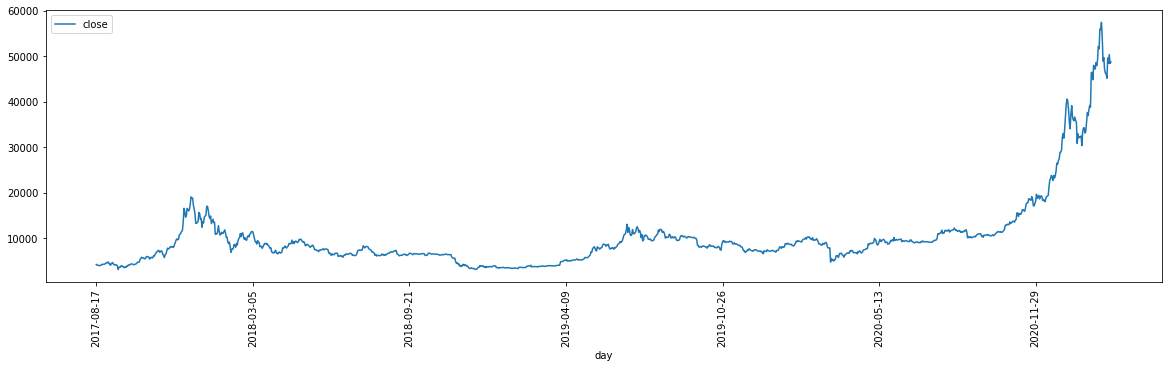

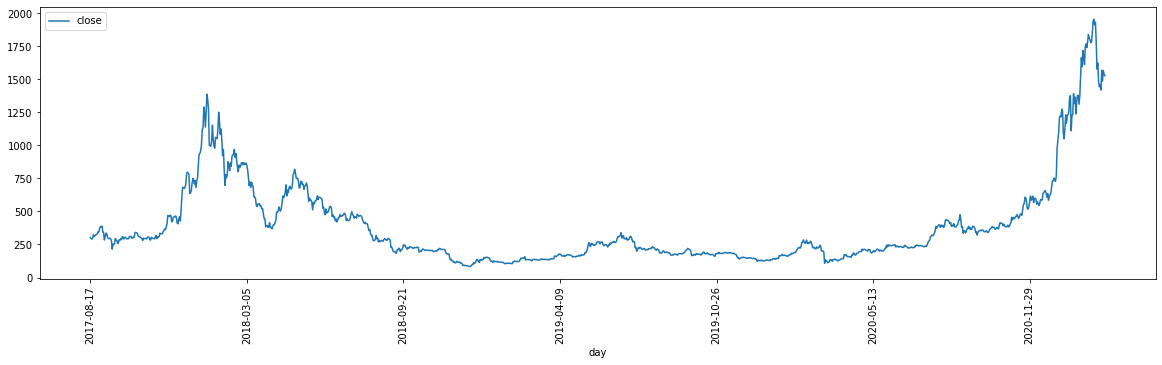

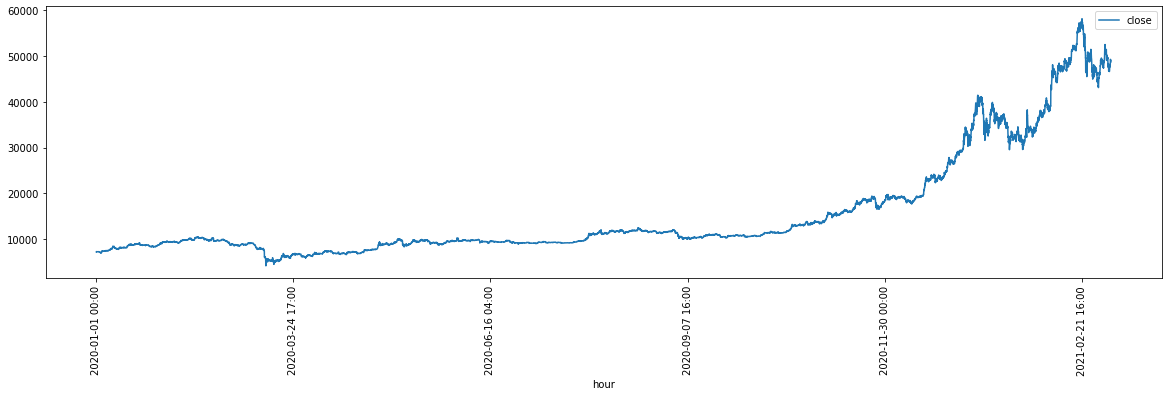

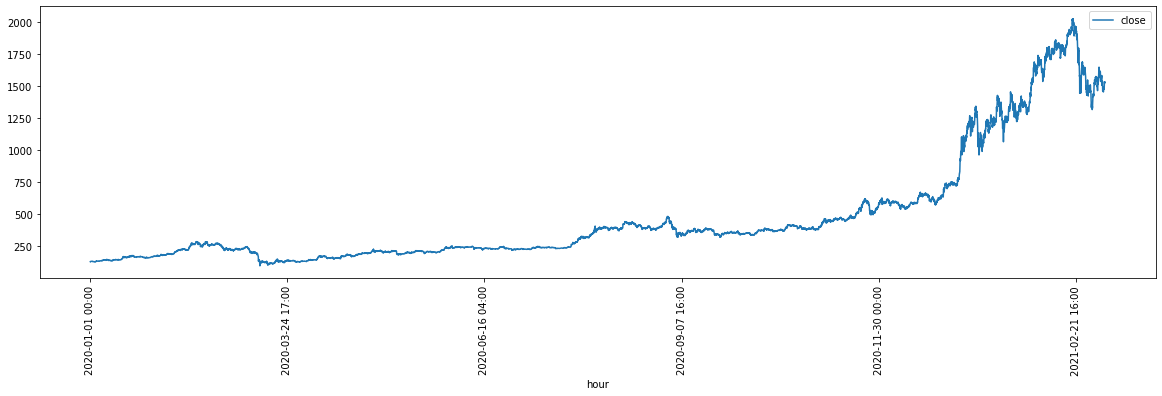

In [9]:
# draw the whole time-range graph
def overall_plot(data):
  cols = getCols(data)
  x_col = 'day'
  if 'hour' in cols:
    x_col = 'hour'
  tmp = data
  tmp.plot(x = x_col, y = ['close'], figsize=(20, 5), rot=90)
  return 
# btc_day, eth_day, btc_hour, eth_hour
overall_plot(btc_day)
overall_plot(eth_day)
overall_plot(btc_hour)
overall_plot(eth_hour)

In [10]:
import time

start_timer = time.time()

# btc_day, eth_day, btc_hour, eth_hour

# to test several thousands of parameters systematically
# researchMACD(btc_day, 'btc_day')
# researchEMA(btc_day, 'btc_day')

# to test parameters once
info, detail = EMA_launch(btc_day, 12, 26)
# info, detail = MACD_launch(btc_day, 12, 26, 9)

end_timer = time.time()
time_interval = end_timer - start_timer

print('time used: ', time_interval)

info, detail
info

time used:  0.06568479537963867


{'accumulated': 6.967,
 'average': 0.387,
 'max_loss': -0.136,
 'max_win': 3.412,
 'win_ratio': 0.389}

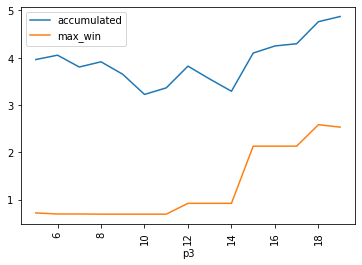

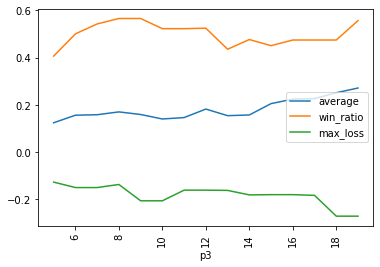

In [11]:
# draw the plot for performance analysis
def drawGraph(ti, x_col):
  tmp = ti
  tmp.plot(x = x_col, y = ['accumulated', 'max_win'], rot=90)
  y_cols=['average', 'win_ratio', 'max_loss']
  tmp.plot(x = x_col, y = y_cols, rot=90)
  return 

# btc_day, eth_day, btc_hour, eth_hour

# performance analysis
ema_fn = ['ema_btc_day.csv', 'ema_eth_day.csv', 'ema_btc_hour.csv', 'ema_eth_hour.csv']
macd_fn = ['macd_btc_day.csv', 'macd_eth_day.csv', 'macd_btc_hour.csv', 'macd_eth_hour.csv']

# df = pd.read_csv(ema_fn[0])
df = pd.read_csv(macd_fn[0])

# set p1, p2, and p3 as x-col to draw line graph
ti = df.loc[ df['p1']==29 ]
ti = ti.loc[ df['p2']==56 ]

drawGraph(ti, 'p3')

In [19]:
# performance analysis
ema_fn = ['ema_btc_day.csv', 'ema_eth_day.csv', 'ema_btc_hour.csv', 'ema_eth_hour.csv']
macd_fn = ['macd_btc_day.csv', 'macd_eth_day.csv', 'macd_btc_hour.csv', 'macd_eth_hour.csv']

# find the best value for each column
cols = ['average', 'accumulated', 'win_ratio', 'max_win', 'max_loss']
i = 4 # i, choose which column

EMA_or_MACD = False # true -> EMA, False -> MACD

for idx in range(4):
  if EMA_or_MACD:
    df = pd.read_csv(ema_fn[idx]) # EMA-indicator
  else:
    df = pd.read_csv(macd_fn[idx]) # MACD-indicator
  tmp = df.sort_values(by=[cols[i]], ascending=False)
  print(tmp[cols[i]][:1])

6119   -0.103
Name: max_loss, dtype: float64
1683   -0.186
Name: max_loss, dtype: float64
5595   -0.048
Name: max_loss, dtype: float64
4508   -0.065
Name: max_loss, dtype: float64


In [18]:
# performance analyse
ema_fn = ['ema_btc_day.csv', 'ema_eth_day.csv', 'ema_btc_hour.csv', 'ema_eth_hour.csv']
macd_fn = ['macd_btc_day.csv', 'macd_eth_day.csv', 'macd_btc_hour.csv', 'macd_eth_hour.csv']

# to calculate the average value for the top-10 best
cols = ['average', 'accumulated', 'win_ratio', 'max_win', 'max_loss']
i = 1 # i, choose which column

EMA_or_MACD = False # true -> EMA, False -> MACD

for idx in range(4):
  if EMA_or_MACD:
    df = pd.read_csv(ema_fn[idx])
    tmp = df.sort_values(by=[cols[i]], ascending=False)
    print(tmp['p1'][:10].sum()/10, tmp['p2'][:10].sum()/10)
  else:
    df = pd.read_csv(macd_fn[idx])
    tmp = df.sort_values(by=[cols[i]], ascending=False)
    print(tmp['p1'][:10].sum()/10, tmp['p2'][:10].sum()/10, tmp['p3'][:10].sum()/10)


20.2 39.7 17.3
26.2 50.3 11.8
20.6 31.0 18.0
19.5 35.1 14.2
